In [5]:
import numpy as np
import rasterio
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Polygon
import pygeos
gpd.options.use_pygeos = True

/Users/amschel/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [25]:
cover = np.load("data/clean/cover_tropics.npy")
mask = np.load("data/clean/mask_tropics.npy")
loss = np.load("data/clean/loss_tropics.npy")

In [9]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    
    def hex_to_rgb(value):
        '''
        Converts hex to rgb colours
        value: string of 6 characters representing a hex colour.
        Returns: list length 3 of RGB values'''
        value = value.strip("#") # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


    def rgb_to_dec(value):
        '''
        Converts rgb to decimal colours (i.e. divides each value by 256)
        value: list (length 3) of RGB values
        Returns: list (length 3) of decimal values'''
        return [v/256 for v in value]

    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

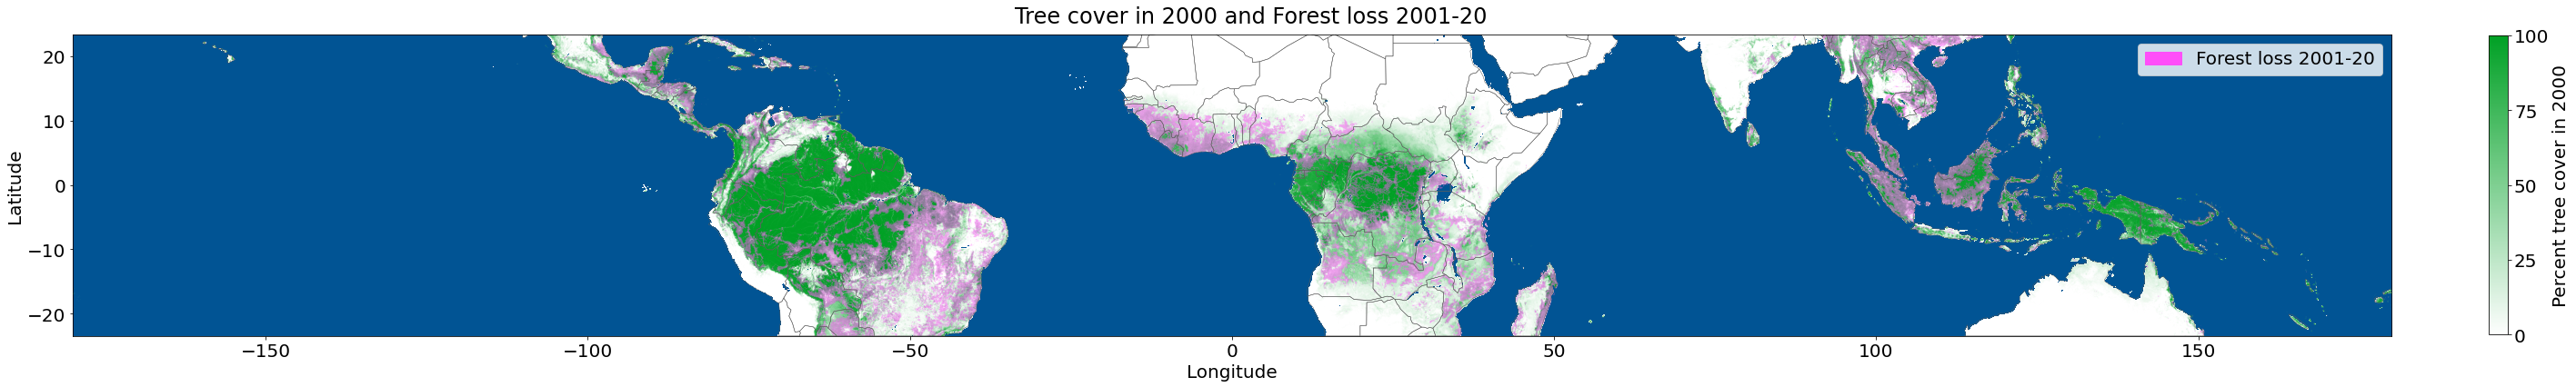

In [37]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

cancer = 23.4394
capricorn = -23.4394
polygon = Polygon([(-180, capricorn), (-180, cancer), (180, cancer), (180, capricorn), (-180, capricorn)])

covern = normalize(cover)
maskn = normalize(mask)
lossn = normalize(loss)
# loss_max_n = normalize(loss_max)
# loss_year_n = normalize(loss_year)
# loss_sum_n = normalize(loss_sum)

### NB loss data currently only valid as binary
# 0 is no loss
# > 0 is loss (but actual actual figures are misleadingly compressed)
hasloss = normalize((loss > 0).astype(int))
hascover = normalize((cover > 0).astype(int))

# losscover = np.stack([hasloss, covern, np.zeros(covern.shape)])
# print(losscover.shape)

transform = rasterio.Affine(0.05, 0, -180, 0, -0.05, cancer)

f, ax = plt.subplots(figsize=(48, 7))

mpl.rcParams.update({'font.size': 20})

grey = "#015494"
white = "#FFFFFF"
green = "#00A125"
pink = "#FF4FF9"
darkred = "#700000"
lightred = "#FFA5A5"

greycmap = ListedColormap([white, grey])
greencmap = ListedColormap([green, green])
whitegreencmap = get_continuous_cmap([white, green])
pinkcmap = ListedColormap([pink, pink])
redmap = get_continuous_cmap([lightred, darkred])
redmap2 = LinearSegmentedColormap.from_list("red2", [lightred, darkred], N=20)
whitepinkcmap = ListedColormap([white, pink])

show(mask!=1, cmap=greycmap, ax=ax, transform=transform)
show(hascover, cmap=whitegreencmap, alpha=covern, ax=ax, transform=transform)
show(hasloss, cmap=pinkcmap, alpha=hasloss*0.5, ax=ax, transform=transform)
# show(hascover, cmap=whitegreencmap, alpha=covern*0.7, ax=ax, transform=transform)

# show(losscover, alpha=hascover, ax=ax, transform=transform)

world = (
    gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        .to_crs(crs="EPSG:4326")
        .pipe(gpd.clip, polygon)
)

world.boundary.plot(linewidth=0.5, color="#5F5F5F", ax=ax)

import matplotlib.patches as mpatches
loss_patch = mpatches.Patch(color=pink, label='Forest loss 2001-20')
ax.legend(handles=[loss_patch])

plt.colorbar(
    plt.cm.ScalarMappable(
        cmap=whitegreencmap,
        norm=mpl.colors.Normalize(vmin=0,vmax=100)
    ),
    ticks=np.linspace(0,100,5),
    fraction=1/130, pad=0.04, aspect=16,
    label="Percent tree cover in 2000", # aspect=80
)

# plt.colorbar(
#     plt.cm.ScalarMappable(
#         cmap=redmap2,
#         norm=mpl.colors.Normalize(vmin=2000.5,vmax=2020.5)
#     ),
#     ticks=[2001,2005,2010,2015,2020],
#     fraction=1/125, pad=0.01, aspect=16,
#     label="\nYear of forest loss", # aspect=80
# )

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")


f.suptitle("Tree cover in 2000 and Forest loss 2001-20",y=0.87, va="center")


plt.savefig("output/graphs/rasterplot", facecolor="white", bbox_inches="tight")

In [ ]:
# def normalize(array):
#     """Normalizes numpy arrays into scale 0.0 - 1.0"""
#     array_min, array_max = array.min(), array.max()
#     return ((array - array_min)/(array_max - array_min))

# polygon = Polygon([(-180, capricorn), (-180, cancer), (180, cancer), (180, capricorn), (-180, capricorn)])

# maskn = normalize(mask)

# for year in range(2001,2021):

#     lossyear = year - 2000
#     print(lossyear)
#     lossn = normalize((loss == lossyear).astype(int))
#     cover_remaining = cover * ((loss >= lossyear) | (loss == 0)).astype(int)
#     covern = normalize(cover_remaining)
#     hasloss = normalize((loss > 0).astype(int))
#     hascover = normalize((cover_remaining > 0).astype(int))

#     # losscover = np.stack([hasloss, covern, np.zeros(covern.shape)])
#     # print(losscover.shape)
#     # print(np.unique(lossn))

#     transform = rasterio.Affine(0.05, 0, -180, 0, -0.05, cancer)

#     f, ax = plt.subplots(figsize=(38, 7))

#     mpl.rcParams.update({'font.size': 20})

#     grey = "#015494"
#     white = "#FFFFFF"
#     green = "#00A125"
#     pink = "#FF4FF9"
#     darkred = "#700000"
#     lightred = "#FFA5A5"

#     greycmap = ListedColormap([white, grey])
#     greencmap = ListedColormap([green, green])
#     whitegreencmap = get_continuous_cmap([white, green])
#     pinkcmap = ListedColormap([pink, pink])
#     redmap = get_continuous_cmap([lightred, darkred])
#     redmap2 = LinearSegmentedColormap.from_list("red2", [lightred, darkred], N=20)
#     whitepinkcmap = ListedColormap([white, pink])

#     show(mask!=1, cmap=greycmap, ax=ax, transform=transform)
#     show(hascover, cmap=whitegreencmap, alpha=covern, ax=ax, transform=transform)
#     show(lossn, cmap=redmap, alpha=lossn*1, ax=ax, transform=transform)
#     # show(hascover, cmap=whitegreencmap, alpha=covern*0.7, ax=ax, transform=transform)

#     # show(losscover, alpha=hascover, ax=ax, transform=transform)

#     world = (
#         gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#             .to_crs(crs="EPSG:4326")
#             .pipe(gpd.clip, polygon)
#     )

#     world.boundary.plot(linewidth=0.5, color="#5F5F5F", ax=ax)

#     import matplotlib.patches as mpatches
#     loss_patch = mpatches.Patch(color=darkred, label='Forest loss')
#     ax.legend(handles=[loss_patch])

#     plt.colorbar(
#         plt.cm.ScalarMappable(
#             cmap=whitegreencmap,
#             norm=mpl.colors.Normalize(vmin=0,vmax=100)
#         ),
#         ticks=np.linspace(0,100,5),
#         fraction=1/130, pad=0.01, aspect=16,
#         label="Percent tree cover in 2000", # aspect=80
#     )

#     # plt.colorbar(
#     #     plt.cm.ScalarMappable(
#     #         cmap=redmap2,
#     #         norm=mpl.colors.Normalize(vmin=2000.5,vmax=2020.5)
#     #     ),
#     #     ticks=[2001,2005,2010,2015,2020],
#     #     fraction=1/125, pad=0.01, aspect=16,
#     #     label="\nYear of forest loss", # aspect=80
#     # )

#     ax.set_ylabel("Latitude")
#     ax.set_xlabel("Longitude")


#     f.suptitle(f"Tree cover in 2000 and Forest loss {year}",y=0.87, va="center")


#     plt.savefig(f"graphs/rasterplot_{year}", facecolor="white", bbox_inches="tight")